This simulation aims to model a three-lane road with heterogeneous vehicles.   

Road features
The road has a PUV lane for jeepneys and minibuses. The rightmost lane is the PUV lane. "Lanes" should not be confused with "cell rows". One lane is two cells wide. In this simulation, 
the road has 3 lanes, and hence, 6 cells wide. An additional 1-cell row is added to serve as a pedestrian holding area for passengers waiting for a ride to public utility vehicles.

Boundary conditions
Vehicles appear on the beginning of the road on a certain probability. When it reaches the end, it disappears.

Vehicles and its behavior

1. Cars (2x2) - Confined to the two lanes together with trucks and motorcycles. Capable of lane changing.
2. Motorcycles (1x1) - Confined to the two lanes together with trucks and cars. Capable of lane changing.
3. Trucks(7x2) - Confined to the two lanes together with cars and motorcycles. Capable of lane changing.

4. Jeep (3x2) - Public Utility vehicle. Confined in the PUV lane with minibuses. Cannot change lane. This vehicle makes sudden stops to load/unload passengers.
5. Minibuses (4x2) - Public Utility vehicle. Confined in the PUV lane with minibuses. Cannot change lane. This vehicle makes sudden stops to load/unload passengers.

Passenger Count per Vehicle
We define passenger as an individual that needs to ride a specific mode of transportation to move from one place to another. Truck drivers and conductors are not counted as passengers. Passengers also include PUVs, car and motorcycle drivers. 

1. Cars(can accomodate 1-5 passengers)
2. Motorcycles(can accomodate 1-2 passengers)
3. Trucks(0 passengers, load mainly for commercial purposes)
4. Jeep (can accomodate 20-25 passengers)'
5. Minibuses(can accomodate (25-27 passengers)

Let's start with the case of no lane changing on non-PUV lanes.

In [52]:
import numpy as np
import matplotlib.pyplot as plt

In [53]:
class Vehicle:
    def __init__(self, x_position, speed, max_speed, length, width, road_designation, vehicle_type, current_lane, lane_changing_prob):
        self.x_position = x_position
        self.speed = speed
        self.max_speed = max_speed
        self.braking_prob = 0.01
        self.length = length
        self.width = width
        self.road_designation = road_designation
        self.vehicle_type = vehicle_type
        self.current_lane = current_lane
        self.lane_changing_prob = lane_changing_prob

    def accelerate(self):
        if self.speed < self.max_speed:
            self.speed += 1 

    def decelerate(self, gap_distance):
        if self.speed > gap_distance:
            self.speed = gap_distance

    def randomize(self, braking_prob):
        if np.random.rand() < braking_prob:
            if self.speed > 0:
                self.speed -= 1

    def lane_changing(self):
        if np.random.rand() < self.lane_changing_prob:
            if self.vehicle_type in ['motorcycle', 'car', 'truck']:
                if self.current_lane < self.road_designation.road_width - 1 and self.current_lane > 2:
                    self.current_lane += 1
                elif self.current_lane > 3:
                    self.current_lane -= 1

In [54]:
class Road:
    def __init__(self, road_length, road_width, speed_limit):
        self.road_length = road_length
        self.road_width = road_width
        self.speed_limit = speed_limit
        self.road_occupancy = np.zeros((road_length, road_width))

In [66]:
class IntraRoadSimulator:
    def __init__(self, road):
        self.road = road
        self.car_production_prob = 0.9
        self.jeep_production_prob = 0.9
        self.minibus_production_prob = 0.2
        self.truck_production_prob = 0.9
        self.motor_production_prob = 0.9
        self.vehicles = []

    def update_occupancy(self):
        self.road.road_occupancy.fill(0)
        for vehicle in self.vehicles:
            if vehicle.x_position < self.road.road_length:
                x_start = vehicle.x_position
                x_end = min(vehicle.x_position + vehicle.length, self.road.road_length)
                y_start = vehicle.current_lane
                y_end = min(vehicle.current_lane + vehicle.width, self.road.road_width)
                self.road.road_occupancy[x_start:x_end, y_start:y_end] = 1

    def produce_vehicles(self):
        vehicle_type = None
        vehicle_length = 0
        vehicle_width = 0
        current_lane = 0
        lane_changing_prob = 0

        if np.random.rand() < self.car_production_prob:
            vehicle_type = 'car'
            vehicle_length = 2
            vehicle_width = 2
            current_lane = np.random.choice(range(3, self.road.road_width - 1, 1))
            lane_changing_prob = 0.01
        elif np.random.rand() < self.truck_production_prob:
            vehicle_type = 'truck'
            vehicle_length = 7
            vehicle_width = 2
            current_lane = np.random.choice(range(3, self.road.road_width - 1, 1))
            lane_changing_prob = 0.01
        elif np.random.rand() < self.motor_production_prob:
            vehicle_type = 'motorcycle'
            vehicle_length = 1
            vehicle_width = 1
            current_lane = np.random.choice(range(3, self.road.road_width - 1, 1))
            lane_changing_prob = 0.01
        elif np.random.rand() < self.jeep_production_prob:
            vehicle_type = 'jeep'
            vehicle_length = 3
            vehicle_width = 2
            current_lane = np.random.choice([1, 2])
            lane_changing_prob = 0
        elif np.random.rand() < self.minibus_production_prob:
            vehicle_type = 'minibus'
            vehicle_length = 4
            vehicle_width = 2
            current_lane = np.random.choice([1, 2])
            lane_changing_prob = 0

        return vehicle_type, vehicle_length, vehicle_width, current_lane, lane_changing_prob

    def road_checker(self, vehicle_type, vehicle_length, vehicle_width, current_lane, lane_changing_prob):
        road_portion_checked = self.road.road_occupancy[0:vehicle_length, current_lane:current_lane + vehicle_width]
        if np.sum(road_portion_checked) == 0:
            new_vehicle = Vehicle(0, np.random.randint(1, self.road.speed_limit + 1), self.road.speed_limit, vehicle_length, vehicle_width, self.road, vehicle_type, current_lane, 0.3)
            self.vehicles.append(new_vehicle)
            self.road.road_occupancy[0:new_vehicle.length, current_lane:current_lane + new_vehicle.width] = 1

    def gap_distance(self, vehicle):
        current_x_position = vehicle.x_position
        maximum_possible_distance = self.road.road_length - current_x_position - vehicle.length
        for distance in range(1, maximum_possible_distance + 1):
            next_x_position = current_x_position + vehicle.length + distance
            if np.any(self.road.road_occupancy[next_x_position:vehicle.length, vehicle.current_lane:vehicle.width] == 1):
                return distance
        return maximum_possible_distance

    def update(self):
        vehicle_type, vehicle_length, vehicle_width, current_lane, lane_changing_prob = self.produce_vehicles()
        self.road_checker(vehicle_type, vehicle_length, vehicle_width, current_lane, lane_changing_prob)
        self.update_occupancy()
        
        for vehicle in self.vehicles:
            distance_to_next = self.gap_distance(vehicle)
            vehicle.accelerate()
            vehicle.decelerate(distance_to_next)
            vehicle.randomize(vehicle.braking_prob)
            vehicle.x_position += vehicle.speed
            vehicle.lane_changing()
        
        self.vehicles = [v for v in self.vehicles if v.x_position < self.road.road_length]  # Remove vehicles that have exited the road

        self.update_occupancy()

    def visualize_road(self, T):
    # Initialize a 3D array to hold the state of the road at each timestep.
        road_states = np.zeros((T, self.road.road_length, self.road.road_width))
    
        for timestep in range(T):
            self.update()
            for vehicle in self.vehicles:
                for j in range(vehicle.length):
                    if vehicle.x_position + j < self.road.road_length:
                        road_states[timestep, vehicle.x_position + j, vehicle.current_lane:vehicle.current_lane + vehicle.width] = 1
    
    # Reshape road_states to stack the road width dimension for each timestep
        road_states = road_states.reshape((T * self.road.road_width, self.road.road_length))

    # Create the plot
        plt.figure(figsize=(12, 8))
        plt.imshow(road_states, cmap='binary', aspect='auto', origin='lower')
        plt.xticks(range(0, self.road.road_length, 2))
        plt.yticks(range(0, T * self.road.road_width, self.road.road_width), range(1, T + 1))
        plt.xlabel('Position')
        plt.ylabel('Time Step')
        plt.title('Road Visualization')
        plt.show()

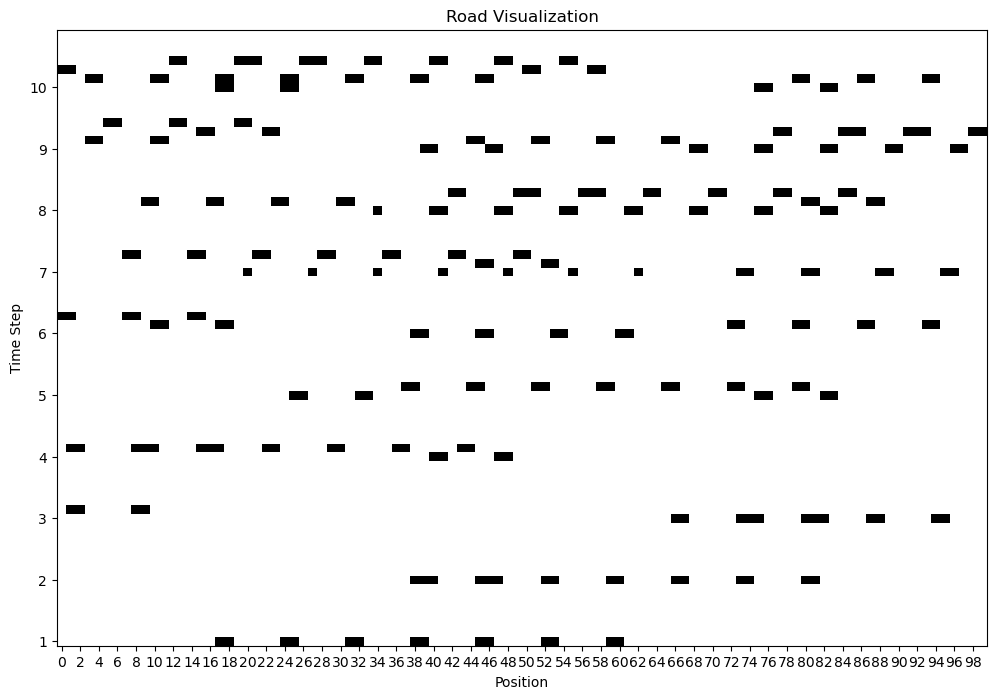

In [67]:
# Define the road
road = Road(road_length=100, road_width=7, speed_limit=5)

# Create the simulator
simulator = IntraRoadSimulator(road)

# Run the simulation and visualize the road
simulator.visualize_road(T=10)